In [1]:
import numpy as np
import pandas as pd
import os

import re
from ast import literal_eval
from datetime import datetime as time
from ast import literal_eval
from sklearn.model_selection import train_test_split

import artm
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gc
import matplotlib.pyplot as plt
%matplotlib inline

/home/vtrokhymenko/proj_news_viz/env4news/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
!ls -lah data/*.csv.bz2

-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 33M Feb 13 11:48 data/Byvsij_SSSR.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 75M Feb 13 11:35 data/Ekonomika.csv.bz2
-rw-rw-r-- 1 vtrokhymenko vtrokhymenko 51M Feb 13 11:45 data/Mir.csv.bz2


In [2]:
name_dataset = 'Mir'

### load data

In [3]:
%%time
df = pd.read_csv(f'data/{name_dataset}.csv.bz2')
print(df.shape)

(82154, 6)
CPU times: user 14.1 s, sys: 198 ms, total: 14.3 s
Wall time: 14.3 s


In [4]:
df.head()

,date,topic,text,predict,text_new,lemmatized_text
0,2008-02-11 10:51:00,"""В России""",- Добивающийся выдвижения кандидатом в презид...,Мир,добивающийся выдвижения кандидатом в президент...,"['добиваться', 'выдвижение', 'кандидат', 'сша'..."
1,2008-02-11 12:15:00,"""В России""",- Министр обороны США Роберт Гейтс заявил что...,Мир,министр обороны сша роберт_гейтс заявил что мо...,"['министр', 'оборона', 'сша', 'роберт_гейтс', ..."
2,2008-02-11 12:46:00,"""В России""",- В США продолжается сезон предварительных вы...,Мир,в сша продолжается сезон предварительных выбор...,"['сша', 'продолжаться', 'сезон', 'предваритель..."
3,2008-02-11 13:16:00,"""В России""","""Американский военнослужащий 38 лет задержан в...",Мир,американский военнослужащий лет задержан в яп...,"['американский', 'военнослужащий', 'задержать'..."
4,2008-02-11 16:14:00,"""В России""",- Сербия в случае признания некоторыми страна...,Мир,сербия в случае признания некоторыми странами ...,"['сербия', 'случай', 'признание', 'некоторый',..."


* parse data

In [5]:
df['year'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[0]))
df['month'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[1]))
df.head()

,date,topic,text,predict,text_new,lemmatized_text,year,month
0,2008-02-11 10:51:00,"""В России""",- Добивающийся выдвижения кандидатом в презид...,Мир,добивающийся выдвижения кандидатом в президент...,"['добиваться', 'выдвижение', 'кандидат', 'сша'...",2008,2
1,2008-02-11 12:15:00,"""В России""",- Министр обороны США Роберт Гейтс заявил что...,Мир,министр обороны сша роберт_гейтс заявил что мо...,"['министр', 'оборона', 'сша', 'роберт_гейтс', ...",2008,2
2,2008-02-11 12:46:00,"""В России""",- В США продолжается сезон предварительных вы...,Мир,в сша продолжается сезон предварительных выбор...,"['сша', 'продолжаться', 'сезон', 'предваритель...",2008,2
3,2008-02-11 13:16:00,"""В России""","""Американский военнослужащий 38 лет задержан в...",Мир,американский военнослужащий лет задержан в яп...,"['американский', 'военнослужащий', 'задержать'...",2008,2
4,2008-02-11 16:14:00,"""В России""",- Сербия в случае признания некоторыми страна...,Мир,сербия в случае признания некоторыми странами ...,"['сербия', 'случай', 'признание', 'некоторый',...",2008,2


In [6]:
df.year.value_counts()

2017    10185
2016    10074
2018     9056
2013     8640
2015     8494
2014     7378
2009     6583
2012     6198
2008     5360
2011     5181
2010     4626
2019      379
Name: year, dtype: int64

In [7]:
df.month.value_counts()

3     7770
10    7351
4     7294
11    7148
7     6827
9     6741
8     6686
12    6581
1     6535
5     6518
6     6423
2     6280
Name: month, dtype: int64

In [8]:
df.lemmatized_text = df.lemmatized_text.apply(lambda x: literal_eval(x))

### preprocess if text with lemma

In [9]:
df['text_join'] = df.text.apply(lambda x: ' '.join(x))
df.head()

,date,topic,text,predict,text_new,lemmatized_text,year,month,text_join
0,2008-02-11 10:51:00,"""В России""",- Добивающийся выдвижения кандидатом в презид...,Мир,добивающийся выдвижения кандидатом в президент...,"[добиваться, выдвижение, кандидат, сша, демокр...",2008,2,- Д о б и в а ю щ и й с я в ы д в и ж е ...
1,2008-02-11 12:15:00,"""В России""",- Министр обороны США Роберт Гейтс заявил что...,Мир,министр обороны сша роберт_гейтс заявил что мо...,"[министр, оборона, сша, роберт_гейтс, моджахед...",2008,2,- М и н и с т р о б о р о н ы С Ш А ...
2,2008-02-11 12:46:00,"""В России""",- В США продолжается сезон предварительных вы...,Мир,в сша продолжается сезон предварительных выбор...,"[сша, продолжаться, сезон, предварительный, вы...",2008,2,- В С Ш А п р о д о л ж а е т с я с ...
3,2008-02-11 13:16:00,"""В России""","""Американский военнослужащий 38 лет задержан в...",Мир,американский военнослужащий лет задержан в яп...,"[американский, военнослужащий, задержать, япон...",2008,2,""" А м е р и к а н с к и й в о е н н о с л у ..."
4,2008-02-11 16:14:00,"""В России""",- Сербия в случае признания некоторыми страна...,Мир,сербия в случае признания некоторыми странами ...,"[сербия, случай, признание, некоторый, независ...",2008,2,- С е р б и я в с л у ч а е п р и з ...


* add docID

In [10]:
df['docID'] = list(range(df.shape[0]))

In [11]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
0,0,2008,2,"[добиваться, выдвижение, кандидат, сша, демокр..."
1,1,2008,2,"[министр, оборона, сша, роберт_гейтс, моджахед..."


In [12]:
print(df.shape)
df.isnull().sum()

(82154, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

In [13]:
df.year.min(),df.year.max()

(2008, 2019)

### preprocess if text full

* get dates

In [ ]:
%%time

df['date_raw'] = df['url'].apply(re.compile('(\d{4})/(\d{2})/(\d{2})').findall)

df['year'] = df['date_raw'].apply(lambda x: int(x[0][0]))
df['month'] = df['date_raw'].apply(lambda x: int(x[0][1]))

* clean text

In [ ]:
import preprocessing_tools as pr

In [ ]:
%%time
df.text = df.text.apply(pr.clean_text)

In [ ]:
df.head(2)

* cleanedNames

In [ ]:
from cleanedNames import KeyProc
cn = KeyProc()

In [ ]:
%%time
df.text = df.text.apply(cn.replaceKeywords)

* lemmatization

In [ ]:
%%time
df['lemmatized_text'] = df.text.apply(pr.lemmatization)

* add docID

In [ ]:
df['docID'] = list(range(df.shape[0]))

In [ ]:
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

In [ ]:
print(df.shape)
df.isnull().sum()

In [ ]:
df.year.min()

## model

* prepare

In [14]:
%%time

vwpath = f'data/vwpath/{name_dataset}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

CPU times: user 548 ms, sys: 106 ms, total: 654 ms
Wall time: 716 ms


In [15]:
id_date = df[['docID', 'year', 'month']].copy()

* collect batchs and collect the dictionary

In [16]:
%%time

batches_path = f'data/batches/{name_dataset}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                        data_format='vowpal_wabbit',
                                        target_folder=batches_path)

print(batch_vectorizer)

artm.BatchVectorizer(data_path="data/batches/Mir", num_batches=84)
CPU times: user 21.5 s, sys: 384 ms, total: 21.9 s
Wall time: 3.95 s


In [17]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)

In [18]:
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=5a691aa8-e0a4-40fe-a87f-f125496d920a, num_entries=23076)

In [19]:
dictionary.save_text(f'data/dicts/dict_{name_dataset}.txt')

## pick up amount topics

In [ ]:
%%time
model_list = []
step, perplexity, sTheta, sPhi = [], [], [], []

start = 6
end = 25
stepp = 1

for i in range(start,end+1,stepp):
    print(f'#topic {i}.........')
    step.append(i)
    date_start = time.now()
    
    num_topics = i
    model = artm.ARTM(num_topics=num_topics, dictionary=dictionary)
    
    # scores
    model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    
    # 1st regularizer
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
    
    # 2st regularizer
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    # 3st regularizer
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)
    
    sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
    sTheta.append(sparsityTheta)
    sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
    sPhi.append(sparsityPhi)
    perpl = model.score_tracker['PerplexityScore'].last_value
    perplexity.append(perpl)
    
    print(f'\tSparsityThetaScore: {sparsityTheta}')
    print(f'\tSparsityPhiScore: {sparsityPhi}')
    print(f'\tPerplexityScore: {perpl}')
    
    print('\ttime:',time.now()-date_start)

In [ ]:
#model_list

In [ ]:
plt.plot(step, sPhi, color='k',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('SparsityPhiScore')

In [ ]:
index_sphi = []
[index_sphi.append(float(str(i)[:3]) ) for i in sPhi]
    
index_sphi = list(set(index_sphi))
index_sphi.sort()
index_sphi

In [ ]:
d_sphi = {}

for j in range(len(index_sphi)):
    k=0
    for i in sPhi:
        if j==range(len(index_sphi))[-1]:
            if (i>=index_sphi[j]):
                k+=1
        else:
            if (i>=index_sphi[j]) & (i<index_sphi[j+1]):
                k+=1
    d_sphi[index_sphi[j]]=k

d_sphi

In [ ]:
plt.plot(step, sTheta, color='g',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()

plt.title('SparsityThetaScore')

In [ ]:
index_theta = []
[index_theta.append(float(str(i)[:3])) for i in sTheta]
    
index_theta = list(set(index_theta))
index_theta.sort()
index_theta

In [ ]:
d_stheta = {}

for j in range(len(index_theta)):
    k=0
    for i in sTheta:
        if j==range(len(index_theta))[-1]:
            if (i>=index_theta[j]):
                k+=1
        else:
            if (i>=index_theta[j]) & (i<index_theta[j+1]):
                k+=1
    d_stheta[index_theta[j]]=k

d_stheta

In [ ]:
plt.plot(step, perplexity, color='b',linewidth=3, marker='x')
ax = plt.gca()
ax.set_xticks(step)
plt.grid()
plt.title('PerplexityScore')

In [ ]:
perplexity

### select the best model

In [ ]:
print(f'd_sphi:   {d_sphi}')
print(f'd_stheta: {d_stheta}')

In [ ]:
select_topics = 20 # u should choose number of topic

best_model = model_list[select_topics-start]
print(best_model.num_topics)

---

In [20]:
select_topics = 17

In [21]:
num_topics = select_topics
model = artm.ARTM(num_topics=num_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# 1st regularizer
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)

# 2st regularizer
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

# 3st regularizer
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

sparsityTheta = model.score_tracker['SparsityThetaScore'].last_value
sparsityPhi = model.score_tracker['SparsityPhiScore'].last_value
perpl = model.score_tracker['PerplexityScore'].last_value

print(f'\tSparsityThetaScore: {sparsityTheta}')
print(f'\tSparsityPhiScore: {sparsityPhi}')
print(f'\tPerplexityScore: {perpl}')


	SparsityThetaScore: 0.6768782138824463
	SparsityPhiScore: 0.8550645709037781
	PerplexityScore: 2171.51611328125


In [22]:
best_model = model.clone()
best_model.num_topics

17

---

### print top words for each topics

In [23]:
phi = best_model.get_phi()
phi['word'] = phi.index
#phi.head()

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")
        #print('\t',phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10])

topic_0: ['землетрясение' 'остров' 'япония' 'китай' 'китайский' 'судно' 'японский'
 'кнр' 'судный' 'километр']
topic_1: ['партия' 'трамп' 'выбор' 'пост' 'дональд_трамп' 'кандидат'
 'президентский' 'парламент' 'голос' 'выборы']
topic_2: ['ес' 'украина' 'европейский' 'германия' 'великобритания' 'европа'
 'евросоюз' 'совет' 'брюссель' 'соглашение']
topic_3: ['самолёт' 'корабль' 'полёт' 'ввс' 'воздушный' 'нато' 'оборона' 'база'
 'вмс' 'граница']
topic_4: ['санкция' 'миллион' 'миллиард' 'случай' 'список' 'ввести' 'финансовый'
 'новый' 'евро' 'запрет']
topic_5: ['корея' 'кндр' 'южный' 'ракета' 'северный' 'ядерный' 'пхеньян'
 'северокорейский' 'южнокорейский' 'испытание']
topic_6: ['подчеркнуть' 'проблема' 'иф' 'хотеть' 'добавить' 'очень' 'москва'
 'вашингтон' 'сотрудничество' 'важный']
topic_7: ['расследование' 'великобритания' 'сотрудник' 'обвинение' 'документ'
 'издание' 'саудовский' 'бывший' 'спецслужба' 'источник']
topic_8: ['оон' 'мид' 'посольство' 'резолюция' 'совет' 'оружие' 'дипломат

### get topics-docs matrix

shape theta: (17, 82475)


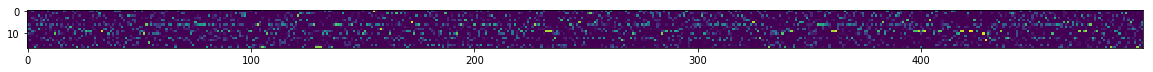

In [24]:
theta = best_model.transform_sparse(batch_vectorizer=batch_vectorizer, eps=0.001)
print(f'shape theta: {theta[0].shape}')

plt.figure(figsize=(20, 20))
plt.imshow(theta[0][:, 2000:2500].toarray());

### dense theta matrix

In [25]:
theta = best_model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T
theta.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16
77000,0.000000,0.342002,0.000000,0.00000,0.000000,0.000000,0.000000,0.275335,0.060151,0.000000,0.0,0.000000,0.000000,0.322513,0.0,0.000000,0.000000
77001,0.000000,0.302953,0.134013,0.00000,0.000000,0.000000,0.310864,0.126049,0.000000,0.000000,0.0,0.000000,0.109054,0.017068,0.0,0.000000,0.000000
77002,0.000000,0.000000,0.054665,0.00000,0.000000,0.237557,0.570953,0.064694,0.000000,0.000000,0.0,0.000000,0.000000,0.012866,0.0,0.059265,0.000000
77003,0.000000,0.000000,0.555030,0.00893,0.059196,0.000000,0.158399,0.043710,0.052438,0.059350,0.0,0.027784,0.000000,0.000000,0.0,0.035165,0.000000
77004,0.205733,0.000000,0.272686,0.00000,0.040223,0.000000,0.085124,0.000000,0.073285,0.079735,0.0,0.000000,0.000000,0.074709,0.0,0.047103,0.121403


## DataViz

In [26]:
joined = id_date.join(theta)
joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16
0,0,2008,2,0.000000,0.929687,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.028721,0.0,0.000000,0.0,0.000000,0.041592
1,1,2008,2,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.433215,0.000000,0.000000,0.0,0.419578,0.093674,0.0,0.000000,0.0,0.025685,0.027848
2,2,2008,2,0.000000,0.740797,0.0,0.000000,0.108779,0.0,0.141671,0.000000,0.000000,0.0,0.003504,0.000000,0.0,0.005249,0.0,0.000000,0.000000
3,3,2008,2,0.082513,0.023565,0.0,0.024114,0.000000,0.0,0.147516,0.093379,0.012368,0.0,0.099413,0.070451,0.0,0.191987,0.0,0.180863,0.073831
4,4,2008,2,0.000000,0.092053,0.0,0.000000,0.000000,0.0,0.288410,0.000000,0.106914,0.0,0.000000,0.000000,0.0,0.463214,0.0,0.000000,0.049409


In [27]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()
print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (132, 17)


topic_0    topic_1    topic_2    topic_3    topic_4    topic_5  \
year month                                                                     
2008 2       6.760820  16.988564  11.355030   4.234299   3.509358   3.774497   
     3      19.255020  41.436459  29.110861  11.005562  21.897743  10.358817   
     4      20.947657  30.673637  35.078758   8.336871  25.490173  14.743146   
     5      60.417076  32.623318  20.478098  11.571239  26.423288   9.893529   
     6      35.398441  26.779856  18.589842   8.825212  21.832909   6.330328   

              topic_6    topic_7    topic_8    topic_9   topic_10   topic_11  \
year month                                                                     
2008 2      19.673176   7.123836  20.806864  19.113255  10.154317  10.602359   
     3      48.750629  20.760441  26.922340  35.120823  33.210773  19.416443   
     4      47.587467  15.434190  25.955400  37.653500  30.521046  10.460304   
     5      32.814495  13.962594  25.693048  65.278725  18.893513  16.976309   
     6      27.317072   8.357778  16.667707  48.337650  21.520412   8.559258   

             topic_12   topic_13   topic_14   topic_15   topic_16  
year month                                                         
2008 2       7.848490  20.522497   5.499299  16.846125  10.187216  
     3      26.978424  28.336536   8.197689  26.453314  17.788130  
     4      22.706640  31.453356   8.364753  30.770609  25.822493  
     5      25.219498  15.017492  13.743458  20.107574  31.886751  
     6      20.612549  16.375538   6.739529  19.883636  18.872286

### straightforward matrix heatmap

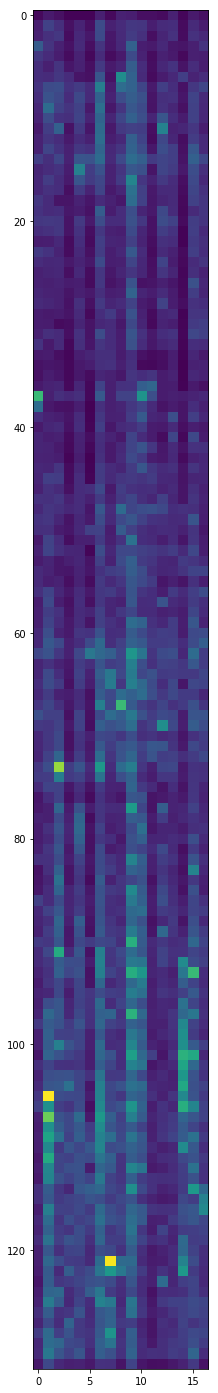

In [28]:
plt.figure(figsize=(5, 25))
plt.imshow(gb[topics])

## pygal

In [29]:
import pygal
from IPython.display import SVG, HTML

In [30]:
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [31]:
max(gb['topic_1'].values)

207.05806

In [32]:
line_chart = pygal.StackedLine(fill=True, show_dots=False)
line_chart.title = 'Topics'
for topic in topics:
    line_chart.add(topic, gb[topic].values)
    
HTML(html_pygal.format(pygal_render=line_chart.render(is_unicode=True)))

In [33]:
line_chart.render_to_file(f"data/visualization/{'-'.join(name_dataset.split('.'))}_pygal.svg")

## joypy

In [34]:
import joypy # !pip install joypy

In [35]:
print(joined.shape)
joined.head()

(82154, 20)


,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16
0,0,2008,2,0.000000,0.929687,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.028721,0.0,0.000000,0.0,0.000000,0.041592
1,1,2008,2,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.433215,0.000000,0.000000,0.0,0.419578,0.093674,0.0,0.000000,0.0,0.025685,0.027848
2,2,2008,2,0.000000,0.740797,0.0,0.000000,0.108779,0.0,0.141671,0.000000,0.000000,0.0,0.003504,0.000000,0.0,0.005249,0.0,0.000000,0.000000
3,3,2008,2,0.082513,0.023565,0.0,0.024114,0.000000,0.0,0.147516,0.093379,0.012368,0.0,0.099413,0.070451,0.0,0.191987,0.0,0.180863,0.073831
4,4,2008,2,0.000000,0.092053,0.0,0.000000,0.000000,0.0,0.288410,0.000000,0.106914,0.0,0.000000,0.000000,0.0,0.463214,0.0,0.000000,0.049409


In [36]:
joined['date'] = ['{}-{:02d}-01'.format(a, b) for a, b in joined[['year', 'month']].values]
cols = [c for c in joined.columns if c.startswith('topic')]

joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,date
0,0,2008,2,0.000000,0.929687,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.028721,0.0,0.000000,0.0,0.000000,0.041592,2008-02-01
1,1,2008,2,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.433215,...,0.000000,0.0,0.419578,0.093674,0.0,0.000000,0.0,0.025685,0.027848,2008-02-01
2,2,2008,2,0.000000,0.740797,0.0,0.000000,0.108779,0.0,0.141671,...,0.000000,0.0,0.003504,0.000000,0.0,0.005249,0.0,0.000000,0.000000,2008-02-01
3,3,2008,2,0.082513,0.023565,0.0,0.024114,0.000000,0.0,0.147516,...,0.012368,0.0,0.099413,0.070451,0.0,0.191987,0.0,0.180863,0.073831,2008-02-01
4,4,2008,2,0.000000,0.092053,0.0,0.000000,0.000000,0.0,0.288410,...,0.106914,0.0,0.000000,0.000000,0.0,0.463214,0.0,0.000000,0.049409,2008-02-01


In [37]:
dd = joined[cols + ['date']].melt('date', var_name='topic', value_name='mentions')
dd = dd[dd['mentions'] > 0]

dd.head()

,date,topic,mentions
3,2008-02-01,topic_0,0.082513
5,2008-02-01,topic_0,0.043220
7,2008-02-01,topic_0,0.150302
18,2008-02-01,topic_0,0.029558
22,2008-02-01,topic_0,0.188537


In [38]:
dd2 = dd.groupby(['date','topic']).sum()
dd2.head()

mentions
date       topic              
2008-02-01 topic_0    6.760820
           topic_1   16.988564
           topic_10  10.154317
           topic_11  10.602359
           topic_12   7.848490

In [39]:
dd2=dd2.reset_index()
dd2.head()

,date,topic,mentions
0,2008-02-01,topic_0,6.760820
1,2008-02-01,topic_1,16.988564
2,2008-02-01,topic_10,10.154317
3,2008-02-01,topic_11,10.602359
4,2008-02-01,topic_12,7.848490


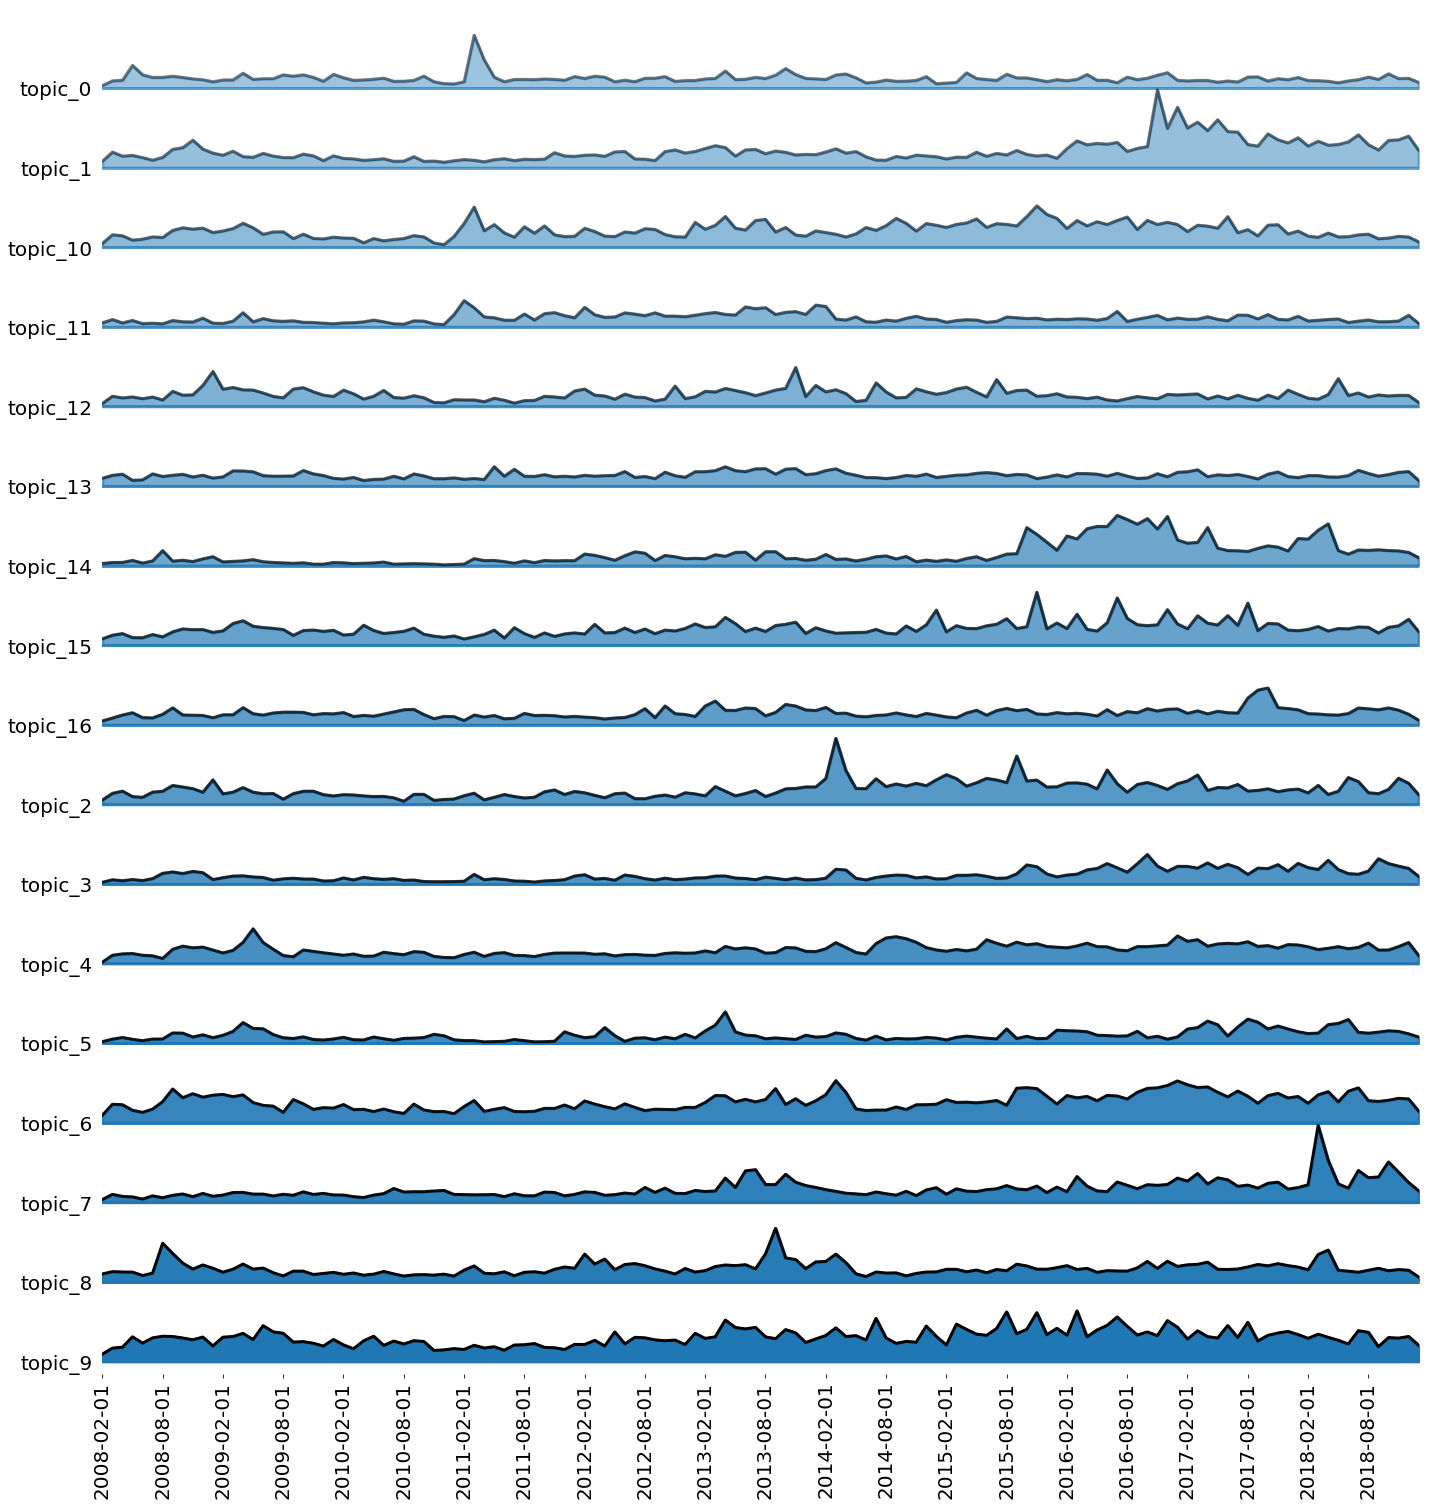

In [40]:
labels = sorted(joined['date'].unique())
fig, axes = joypy.joyplot(dd2, by='topic', column='mentions', figsize=(20, 20),
                          xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True,
                          linecolor="k",linewidth=3,
                          kind='values', fade=True, xrot=90,
                          x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

In [41]:
fig.savefig(f"data/visualization/{'-'.join(name_dataset.split('.'))}_joypy")